# **Implementation of Predicting Number of Patients from Kota Sumenep using GRU Method**


```
This Work Created By Ega Fernanda Putra (502621073)

```





# Importing Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GRU
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Preprocessing Data

##Import Library

melakukan import librarry untuk persiapan praproses data

##Load Dataaset

In [ ]:
# Melakukan Load dataset
ntt = pd.read_csv('https://raw.githubusercontent.com/Arin1206/datasetFPKel10/main/NTT%202015%20-%202022.csv')
ntt.head(10)

,datetime,total_visitor,total_accomodation
0,1/1/2014,22881.0,9024
1,2/1/2014,19794.0,9058
2,3/1/2014,26642.0,9103
3,4/1/2014,33478.0,9187
4,5/1/2014,36289.0,9247
5,6/1/2014,39.1,9271
6,7/1/2014,41911.0,9348
7,8/1/2014,44722.0,9378
8,9/1/2014,47533.0,9400
9,10/1/2014,50344.0,9495


##Display Data Type Information

In [ ]:
ntt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   datetime            108 non-null    object 
 1   total_visitor       108 non-null    float64
 2   total_accomodation  108 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ KB


## Data Duplicate Check

In [ ]:
jumlah_baris_duplikat = ntt.duplicated().sum()
print("Jumlah baris yang memiliki data sama: {} baris".format(jumlah_baris_duplikat))

Jumlah baris yang memiliki data sama: 0 baris


##Missing Values Check

In [ ]:
ntt.isnull().sum()

datetime              0
total_visitor         0
total_accomodation    0
dtype: int64

Didapatkan dari dataset terdapat 0 baris missing value

## Data Type Adjustment

### Change the float data type to integer

In [ ]:
# Mengubah kolom 'total visitor' dari float menjadi integer
ntt['total_visitor'] = ntt['total_visitor'].astype(int)

In [ ]:
ntt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   datetime            108 non-null    object
 1   total_visitor       108 non-null    int64 
 2   total_accomodation  108 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB


### Datetime Formatting

In [ ]:
ntt['datetime'] = pd.to_datetime(ntt['datetime'], format='%m/%d/%Y')
ntt.head()

,datetime,total_visitor,total_accomodation
0,2014-01-01,22881,9024
1,2014-02-01,19794,9058
2,2014-03-01,26642,9103
3,2014-04-01,33478,9187
4,2014-05-01,36289,9247


In [ ]:
ntt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            108 non-null    datetime64[ns]
 1   total_visitor       108 non-null    int64         
 2   total_accomodation  108 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.7 KB


## Outlier Values Check

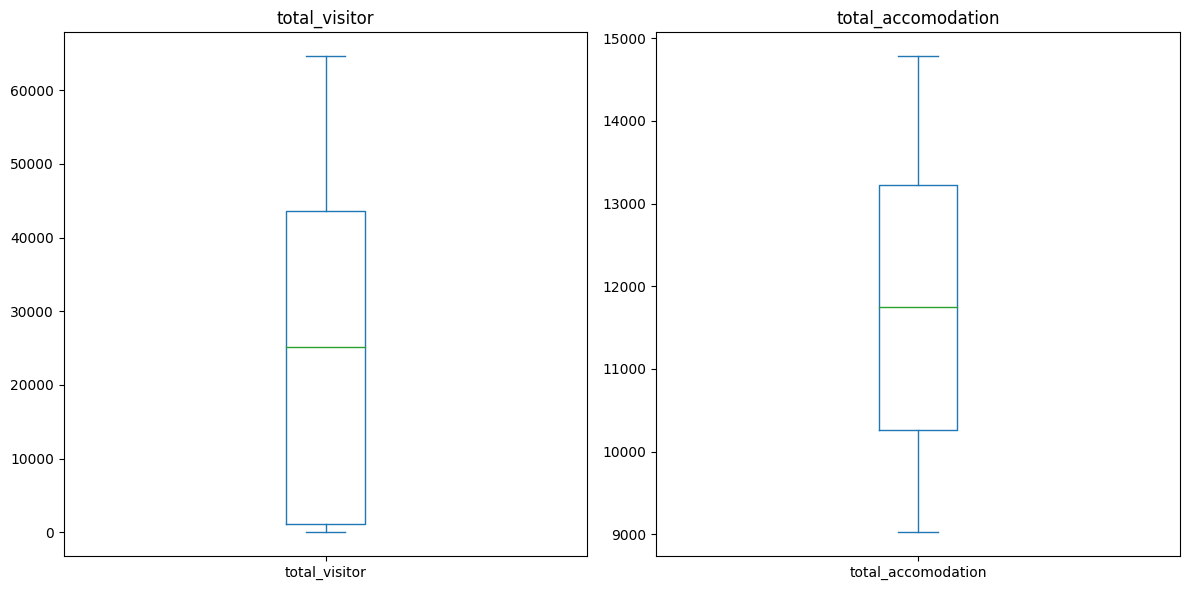

In [ ]:
data_check = ['total_visitor', 'total_accomodation']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, data in enumerate(data_check):
    ntt[data].plot(kind='box', ax=axes[i])
    axes[i].set_title(data)
plt.tight_layout()
plt.show()

In [ ]:
Q1 = ntt[['total_visitor', 'total_accomodation']].quantile(0.25)
Q3 = ntt[['total_visitor', 'total_accomodation']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ntt[((ntt[['total_visitor', 'total_accomodation']] < lower_bound) | (ntt[['total_visitor', 'total_accomodation']] > upper_bound)).any(axis=1)]

print("Baris dengan outlier:")
print(outliers)

Baris dengan outlier:
Empty DataFrame
Columns: [datetime, total_visitor, total_accomodation]
Index: []


In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
input_col = list(ntt)[1:7]
print(input_col)

['total_visitor', 'total_accomodation']


In [ ]:
data_for_training = ntt[input_col].astype(float)

##Normalisasi Data

In [ ]:
# Normalize the data
scaler = StandardScaler()
dataset_scaled = ntt.copy()
for column in ntt.columns:
  dataset_scaled[[column]] = scaler.fit_transform(ntt[[column]])

##One time Series (Sequence)

In [ ]:
# Define sequence length and features
sequence_length = 6  # Number of time steps in each sequence
num_features = len(dataset_scaled.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(dataset_scaled) - sequence_length):
    # Mendapatkan 5 data periode sebelumnya
    seq = dataset_scaled.iloc[i:i+sequence_length]
    # Mendapatkan data periode ke-6 sebagai label, cuma kolom total_visitor
    label = dataset_scaled.iloc[i+sequence_length, 1]  # '_tempm' column index, kalau prediksi lebih dari satu, ganti angkanya
    sequences.append(seq)
    labels.append(label)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(data_for_training)
scaled_data_train = scaler.transform(data_for_training)

# Scenario 1



```
In this scenario i use 24 past data to predict 1 future data this data count
will be used to make trainX and trainY data and it will iterate 96 times because my dataset count is 120,
also i use simple GRU models with 1 only GRU layer + Output Dense Layer
```



In [ ]:
ntt_gru = ntt.copy()

In [ ]:
ntt_gru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            108 non-null    datetime64[ns]
 1   total_visitor       108 non-null    int64         
 2   total_accomodation  108 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.7 KB


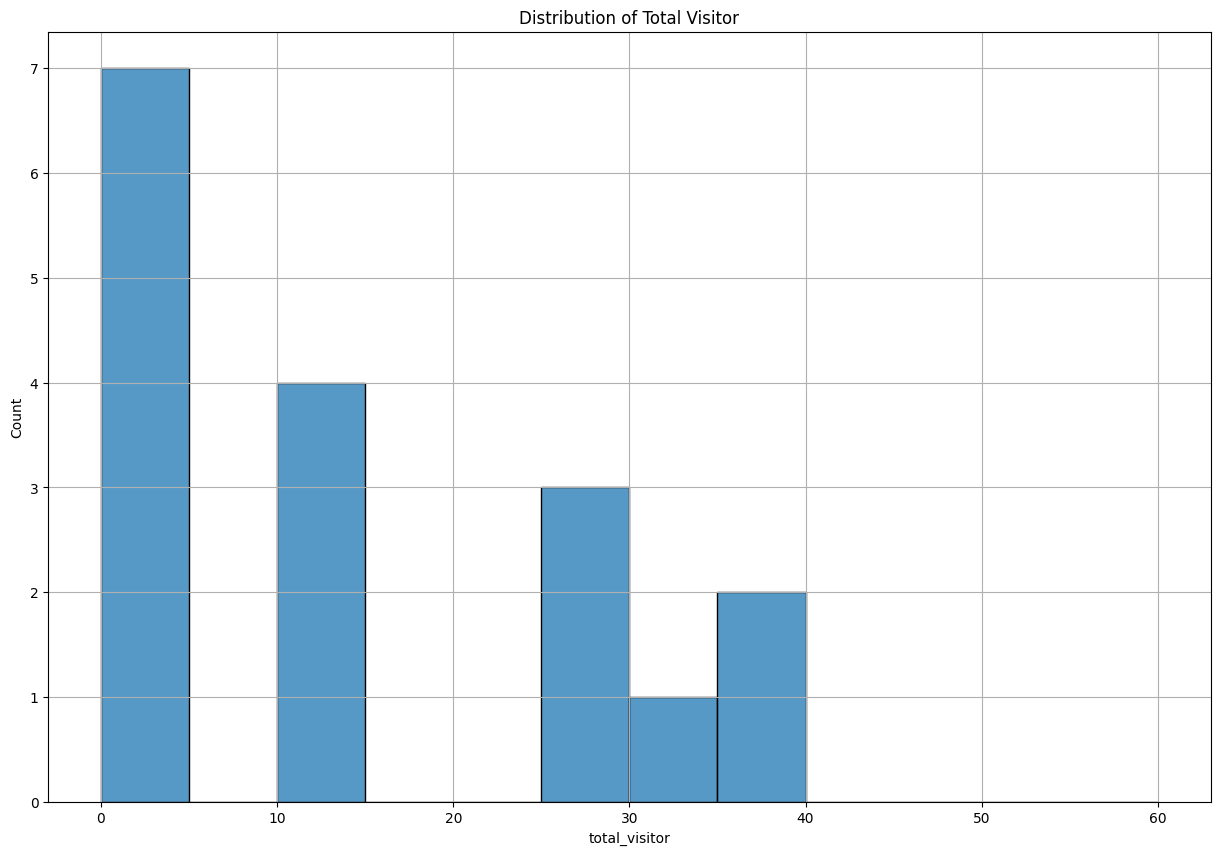

In [ ]:
# plot to see the visitor varience
plt.figure(figsize=(15, 10))
sns.histplot(ntt_gru['total_visitor'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Total Visitor")
plt.grid()
plt.show()

In [ ]:
# Getting trainX and trainY
trainX = []
trainY = []
n_future = 1
n_past = 24

for i in range(n_past, len(scaled_data_train) - n_future + 1):
    trainX.append(scaled_data_train[i - n_past:i, 0:scaled_data_train.shape[1]])
    trainY.append(scaled_data_train[i + n_future - 1:i + n_future, 0])

trainX = np.array(trainX)
trainY = np.array(trainY)

# Memisahkan data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (67, 24, 2).
y_train shape == (67, 1).
X_test shape == (17, 24, 2).
y_test shape == (17, 1).


In [ ]:
# Define the GRU model
model = Sequential()
model.add(GRU(64, activation = 'tanh', input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))

model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                13056     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32,  verbose=2,validation_split=0.2)

Epoch 1/100
3/3 - 3s - loss: 0.8249 - val_loss: 0.7897 - 3s/epoch - 972ms/step
Epoch 2/100
3/3 - 0s - loss: 0.6177 - val_loss: 0.4363 - 74ms/epoch - 25ms/step
Epoch 3/100
3/3 - 0s - loss: 0.4574 - val_loss: 0.1956 - 75ms/epoch - 25ms/step
Epoch 4/100
3/3 - 0s - loss: 0.3400 - val_loss: 0.0512 - 75ms/epoch - 25ms/step
Epoch 5/100
3/3 - 0s - loss: 0.2514 - val_loss: 0.0040 - 78ms/epoch - 26ms/step
Epoch 6/100
3/3 - 0s - loss: 0.2039 - val_loss: 0.0512 - 68ms/epoch - 23ms/step
Epoch 7/100
3/3 - 0s - loss: 0.2019 - val_loss: 0.1613 - 78ms/epoch - 26ms/step
Epoch 8/100
3/3 - 0s - loss: 0.2159 - val_loss: 0.2621 - 78ms/epoch - 26ms/step
Epoch 9/100
3/3 - 0s - loss: 0.2344 - val_loss: 0.2906 - 75ms/epoch - 25ms/step
Epoch 10/100
3/3 - 0s - loss: 0.2223 - val_loss: 0.2302 - 92ms/epoch - 31ms/step
Epoch 11/100
3/3 - 0s - loss: 0.1991 - val_loss: 0.1524 - 73ms/epoch - 24ms/step
Epoch 12/100
3/3 - 0s - loss: 0.1870 - val_loss: 0.0983 - 72ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.1842 -

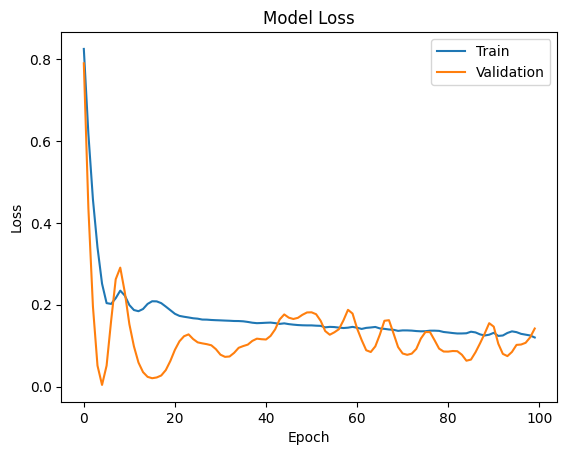

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Melakukan prediksi pada test set
predictions = model.predict(X_test)

1/1 [==============================] - 0s 391ms/step


In [ ]:
def plotting_actual_vs_pred(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Visitor')
    plt.legend()
    plt.show()

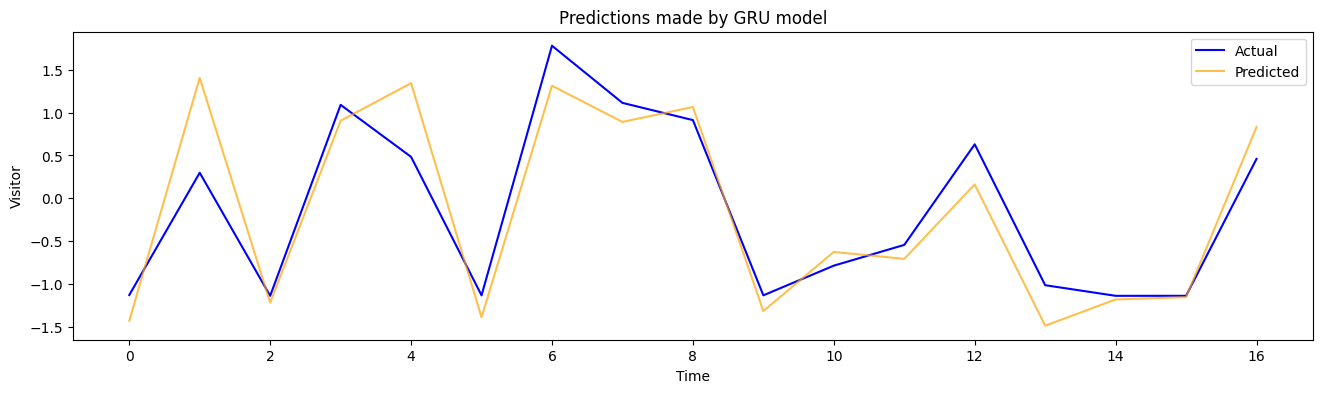

In [ ]:
plotting_actual_vs_pred(y_test, predictions, "Predictions made by GRU model")

##On Train

In [ ]:
# Membuat prediksi visitor menggunakan X_train
y_train_pred = model.predict(X_train)

3/3 [==============================] - 0s 5ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_train
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
y_train_real = scaler.inverse_transform(y_train_copies)[:,1]
y_train_real

array([10000.48114892, 10614.65660256, 10457.74815333, 15022.50152488,
       12744.16234209, 10666.66914097, 12529.54135023, 14539.42616808,
        9911.02274951, 13573.27545448, 10617.26910449, 12942.39582184,
       12585.35389146, 10517.28153063, 10245.66049668, 13731.37140458,
        9906.27274601, 14056.35081128,  9906.19357928,  9905.24357858,
       14371.67187751,  9910.31024899, 11717.68658393,  9905.24357858,
       12400.73708843,  9905.24357858, 13113.95011521, 13134.21679685,
       10438.90647275, 14297.88848968,  9906.19357928, 13814.81313288,
       10525.51487005,  9963.58945501,  9907.30191343, 10215.73547458,
       10682.97748635, 10104.03122541, 13228.02936614, 12438.34128287,
       10595.41908835, 12257.76198283, 10893.08597487, 11319.31962302,
       10656.69413361, 10116.77706815, 10047.11035003,  9907.46024688,
       14202.73008606, 10152.24376102,  9906.27274601,  9905.48107875,
        9923.76859226, 10378.10642784, 11940.8575821 , 12058.974336  ,
      

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_train_pred_copies = np.repeat(y_train_pred, X_train.shape[-1], axis=-1)
y_train_pred_real = scaler.inverse_transform(y_train_pred_copies)[:,1]
y_train_pred_real

array([ 9361.53  , 10772.0625, 10676.593 , 14019.16  , 12330.582 ,
       10674.29  , 12581.962 , 13990.08  ,  9534.937 , 13825.907 ,
       10683.225 , 12537.848 , 12381.663 , 10756.666 ,  9284.0205,
       13354.009 ,  9634.826 , 13979.854 ,  9561.286 ,  9809.094 ,
       13458.023 ,  9510.73  , 11756.864 ,  9958.829 , 12539.063 ,
        9687.705 , 13083.639 , 13636.677 , 10706.041 , 13980.107 ,
        9586.911 , 13946.325 , 12133.542 ,  9372.921 ,  9712.828 ,
       10512.622 , 10646.021 ,  9309.208 , 13213.817 , 12325.284 ,
       10758.661 , 11901.324 , 10669.221 , 12943.69  , 10768.159 ,
        9331.629 ,  9354.731 ,  9789.84  , 12653.235 ,  9326.3   ,
        9757.157 ,  9660.968 ,  9445.481 , 11009.56  , 12666.6   ,
       12728.495 , 10093.697 , 13482.474 , 12607.    , 13092.605 ,
        9351.484 ,  9394.517 , 13808.    ,  9736.814 ,  9468.815 ,
       12420.68  , 10314.1   ], dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_80_train = mean_squared_error(y_train_real, y_train_pred_real)
mae_80_train = mean_absolute_error(y_train_real, y_train_pred_real)
mape_80_train = mean_absolute_percentage_error(y_train_real, y_train_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_80_train, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_80_train, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_80_train, 2)}%")

Mean Absolute Error (MAE): 408.39
Mean Squared Error (MSE): 303187.04
Mean Absolute Percentage Error (MAPE): 0.04%


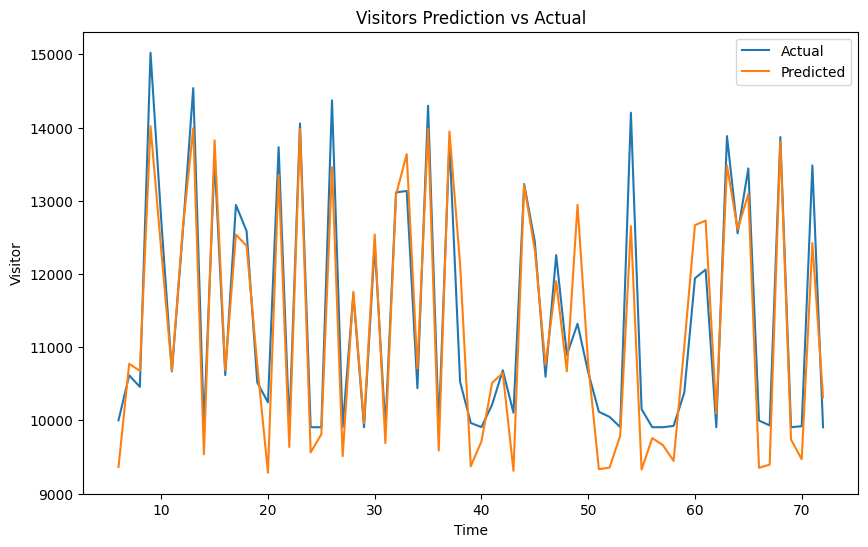

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_real, label='Actual')
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_80_train = []

for time_i in bulanprediksi2:
    bulanforecast_80_train.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_80_train = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_80_train = pd.to_datetime(bulanforecast_80_train, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_train_pred_real sama
min_length = min(len(bulanforecast_80_train), len(y_train_pred_real))
bulanforecast_80_train = bulanforecast_80_train[:min_length]
y_train_pred_real = y_train_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_train_pred_real, columns=['total_visitor'], index=bulanforecast_80_train)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9361 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        10772 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │        10676 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        14019 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        12330 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │        10674 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        12581 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13990 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │         9534 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │        13825 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10683 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

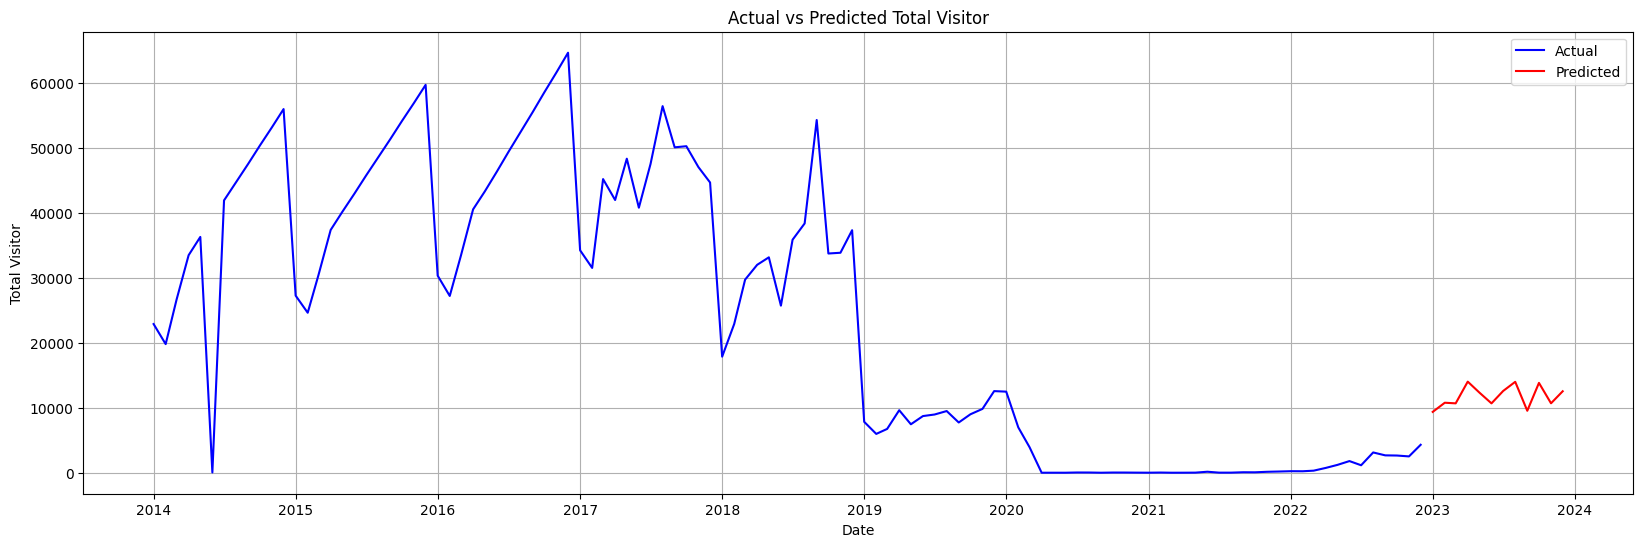

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


## On Test Set

In [ ]:
# Membuat prediksi visitor menggunakan X_test
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_test
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_copies)[:,1]
y_test_real

array([ 9923.13525846, 12306.05368516,  9907.30191343, 13629.0879957 ,
       12615.12058011,  9916.48525355, 14780.96384648, 13667.24635722,
       13331.73777607,  9917.2769208 , 10495.58984795, 10899.65681306,
       12860.06242769, 10114.7187333 ,  9907.69774706,  9908.01441396,
       12576.17055134])

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_test_pred_copies = np.repeat(y_test_pred, X_test.shape[-1], axis=-1)
y_test_pred_real = scaler.inverse_transform(y_test_pred_copies)[:,1]
y_test_pred_real

array([ 9420.012, 14155.73 ,  9774.649, 13319.79 , 14051.088,  9488.76 ,
       14001.599, 13295.406, 13586.996,  9610.798, 10763.132, 10628.19 ,
       12078.179,  9325.045,  9836.759,  9882.214, 13198.13 ],
      dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_80_test = mean_squared_error(y_test_real, y_test_pred_real)
mae_80_test = mean_absolute_error(y_test_real, y_test_pred_real)
mape_80_test = mean_absolute_percentage_error(y_test_real, y_test_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_80_test, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_80_test, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_80_test, 2)}%")

Mean Absolute Error (MAE): 541.21
Mean Squared Error (MSE): 512361.36
Mean Absolute Percentage Error (MAPE): 0.05%


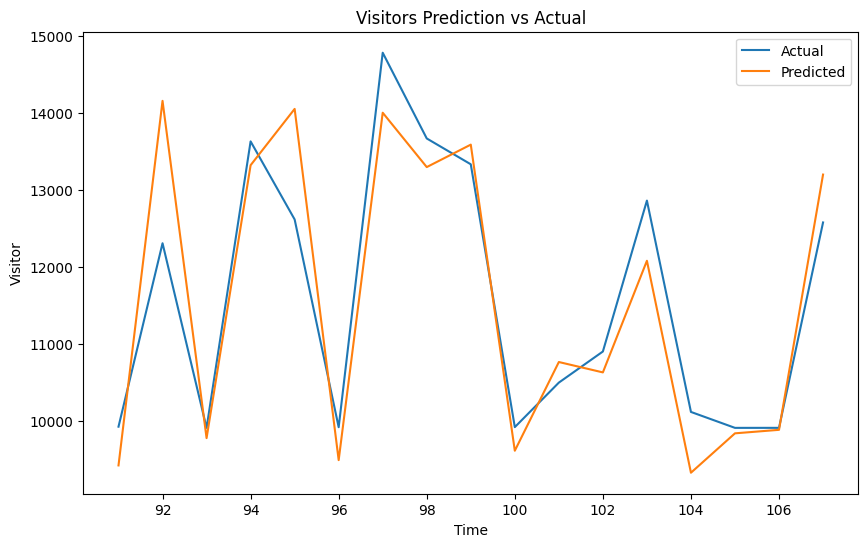

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[-y_test.shape[0]:], y_test_real, label='Actual')
plt.plot(ntt.index[-y_test.shape[0]:], y_test_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_80_test = []

for time_i in bulanprediksi2:
    bulanforecast_80_test.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_80_test = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_80_test = pd.to_datetime(bulanforecast_80_test, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_test_pred_real sama
min_length = min(len(bulanforecast_80_test), len(y_test_pred_real))
bulanforecast_80_test = bulanforecast_80_test[:min_length]
y_test_pred_real = y_test_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_test_pred_real, columns=['total_visitor'], index=bulanforecast_80_test)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9420 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        14155 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │         9774 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        13319 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        14051 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │         9488 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        14001 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13295 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │        13586 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │         9610 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10763 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

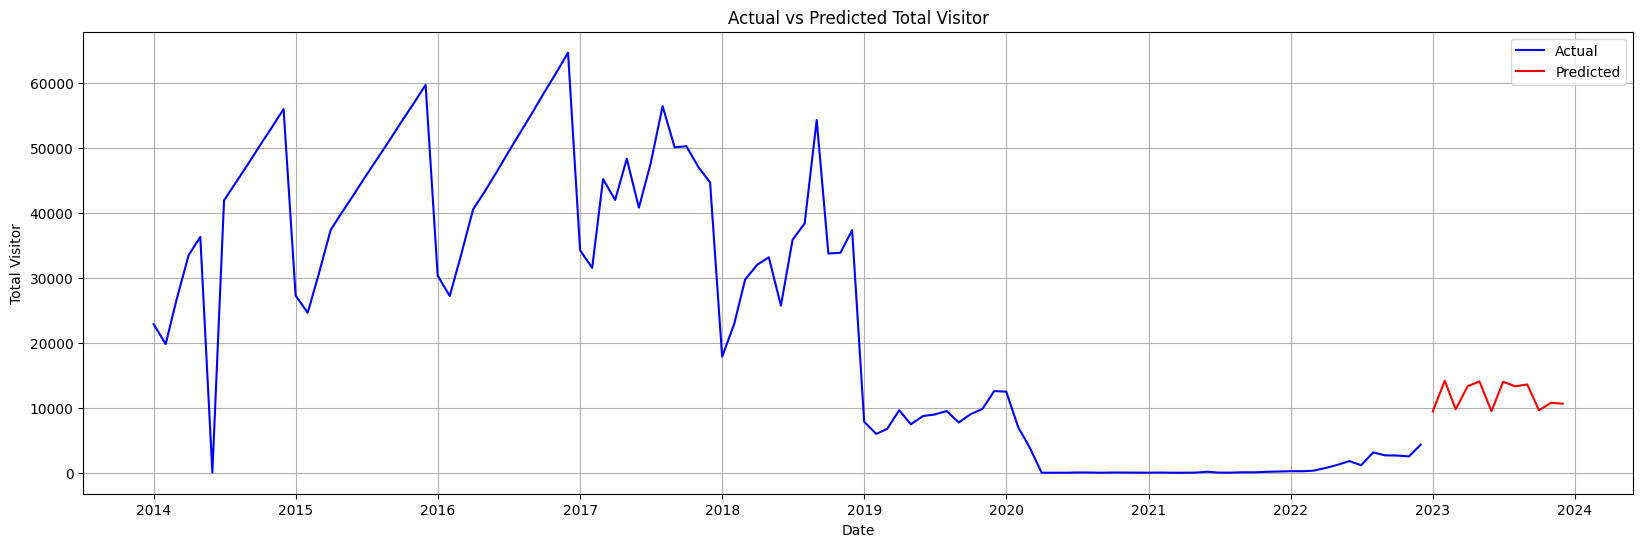

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


# Scenario 2



```
In this scenario i use 24 past data to predict 1 future data this data count
will be used to make trainX and trainY data and it will iterate 96 times because my dataset count is 120,
also i use simple GRU models with 1 only GRU layer + Output Dense Layer
```



In [ ]:
ntt_gru = ntt.copy()

In [ ]:
ntt_gru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            108 non-null    datetime64[ns]
 1   total_visitor       108 non-null    int64         
 2   total_accomodation  108 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.7 KB


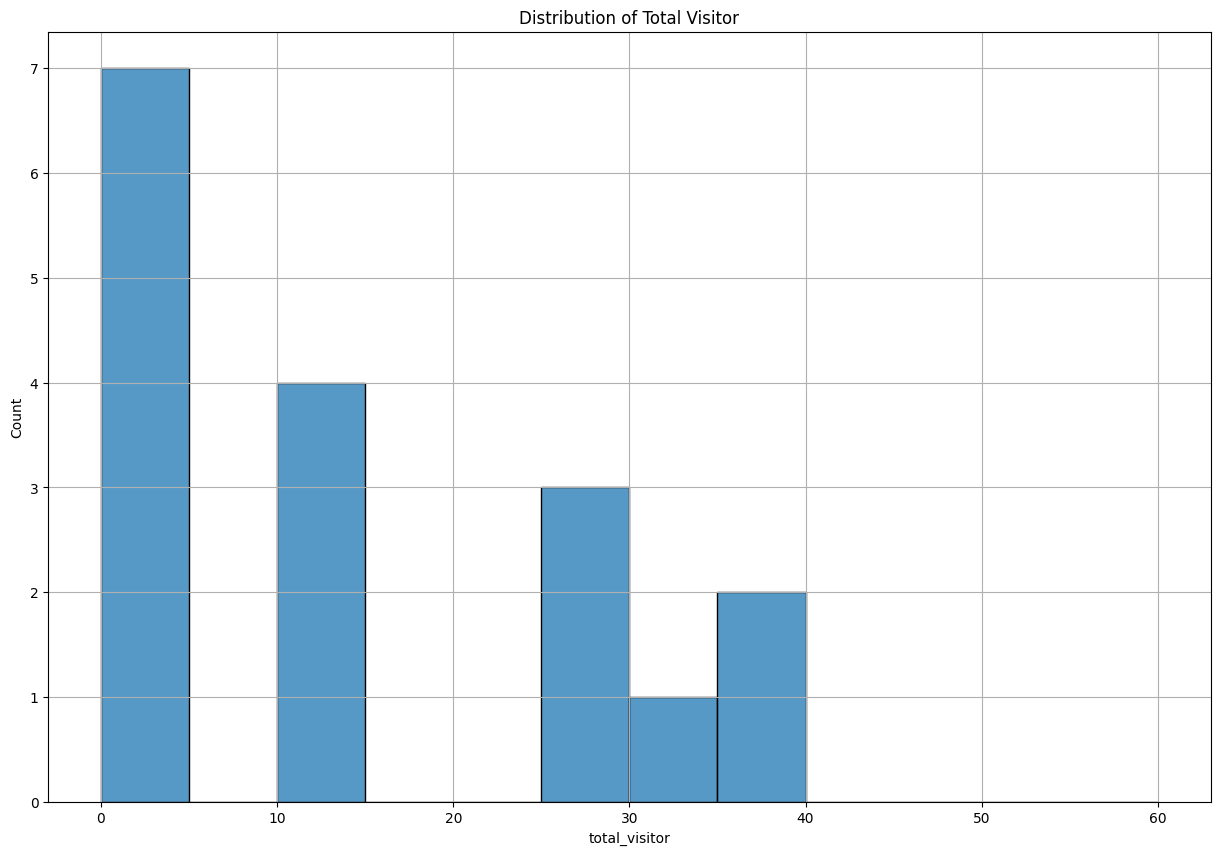

In [ ]:
# plot to see the visitor varience
plt.figure(figsize=(15, 10))
sns.histplot(ntt_gru['total_visitor'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Total Visitor")
plt.grid()
plt.show()

In [ ]:
# Getting trainX and trainY
trainX = []
trainY = []
n_future = 1
n_past = 24

for i in range(n_past, len(scaled_data_train) - n_future + 1):
    trainX.append(scaled_data_train[i - n_past:i, 0:scaled_data_train.shape[1]])
    trainY.append(scaled_data_train[i + n_future - 1:i + n_future, 0])

trainX = np.array(trainX)
trainY = np.array(trainY)

# Memisahkan data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, random_state=42)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (58, 24, 2).
y_train shape == (58, 1).
X_test shape == (26, 24, 2).
y_test shape == (26, 1).


In [ ]:
# Define the GRU model
model = Sequential()
model.add(GRU(64, activation = 'tanh', input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))

model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                13056     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32,  verbose=1, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 4s 402ms/step - loss: 0.9058 - val_loss: 0.8650
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 0.7149 - val_loss: 0.5573
Epoch 3/100
3/3 [==============================] - 0s 51ms/step - loss: 0.5503 - val_loss: 0.2933
Epoch 4/100
3/3 [==============================] - 0s 53ms/step - loss: 0.4189 - val_loss: 0.1185
Epoch 5/100
3/3 [==============================] - 0s 52ms/step - loss: 0.3160 - val_loss: 0.0235
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.2504 - val_loss: 0.0211
Epoch 7/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2234 - val_loss: 0.0985
Epoch 8/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2228 - val_loss: 0.1798
Epoch 9/100
3/3 [==============================] - 0s 30ms/step - loss: 0.2163 - val_loss: 0.2487
Epoch 10/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2107 - val_loss: 0.2771
Epoch 11/100
3/3 [

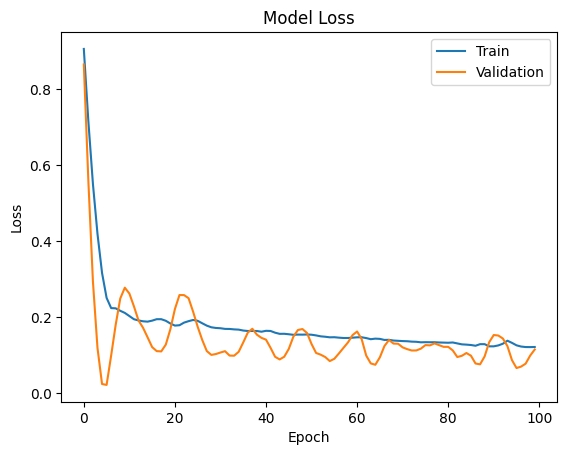

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Melakukan prediksi pada test set
predictions = model.predict(X_test)

1/1 [==============================] - 0s 428ms/step


In [ ]:
def plotting_actual_vs_pred(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Visitor')
    plt.legend()
    plt.show()

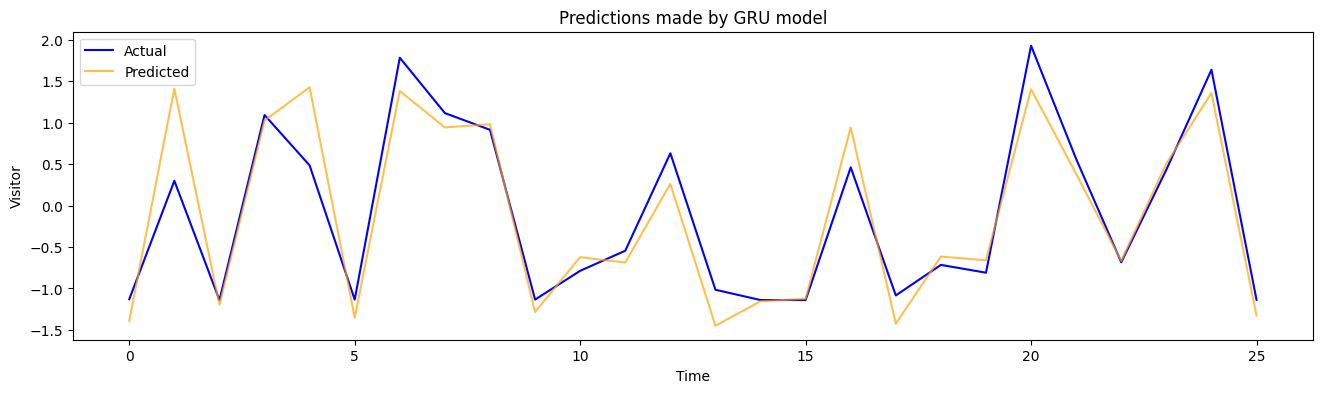

In [ ]:
plotting_actual_vs_pred(y_test, predictions, "Predictions made by GRU model")

##On Train

In [ ]:
# Membuat prediksi visitor menggunakan X_train
y_train_pred = model.predict(X_train)

2/2 [==============================] - 0s 8ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_train
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
y_train_real = scaler.inverse_transform(y_train_copies)[:,1]
y_train_real

array([13573.27545448, 10617.26910449, 12942.39582184, 12585.35389146,
       10517.28153063, 10245.66049668, 13731.37140458,  9906.27274601,
       14056.35081128,  9906.19357928,  9905.24357858, 14371.67187751,
        9910.31024899, 11717.68658393,  9905.24357858, 12400.73708843,
        9905.24357858, 13113.95011521, 13134.21679685, 10438.90647275,
       14297.88848968,  9906.19357928, 13814.81313288, 10525.51487005,
        9963.58945501,  9907.30191343, 10215.73547458, 10682.97748635,
       10104.03122541, 13228.02936614, 12438.34128287, 10595.41908835,
       12257.76198283, 10893.08597487, 11319.31962302, 10656.69413361,
       10116.77706815, 10047.11035003,  9907.46024688, 14202.73008606,
       10152.24376102,  9906.27274601,  9905.48107875,  9923.76859226,
       10378.10642784, 11940.8575821 , 12058.974336  ,  9905.40191203,
       13883.45068357, 12555.5872028 , 13441.22535694,  9996.20614576,
        9930.33943045, 13869.75484012,  9905.56024548,  9919.81025601,
      

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_train_pred_copies = np.repeat(y_train_pred, X_train.shape[-1], axis=-1)
y_train_pred_real = scaler.inverse_transform(y_train_pred_copies)[:,1]
y_train_pred_real

array([13690.836 , 10711.437 , 12676.642 , 12572.095 , 10778.78  ,
        9354.266 , 13368.047 ,  9689.323 , 13969.2295,  9621.537 ,
        9851.476 , 13573.864 ,  9574.36  , 11940.264 , 10015.695 ,
       12739.594 ,  9735.951 , 12995.626 , 13675.318 , 10769.598 ,
       14019.67  ,  9645.033 , 13876.9375, 12266.971 ,  9443.401 ,
        9757.54  , 10554.008 , 10678.647 ,  9377.515 , 13257.765 ,
       12398.408 , 10762.628 , 12015.262 , 10700.349 , 13131.417 ,
       10784.53  ,  9398.647 ,  9422.696 ,  9829.791 , 12809.0625,
        9394.073 ,  9796.644 ,  9712.528 ,  9511.186 , 11136.28  ,
       12758.401 , 12801.104 , 10150.689 , 13658.186 , 12618.342 ,
       13291.264 ,  9417.594 ,  9463.596 , 13949.532 ,  9778.377 ,
        9534.225 , 12554.413 , 10364.494 ], dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_70_train = mean_squared_error(y_train_real, y_train_pred_real)
mae_70_train = mean_absolute_error(y_train_real, y_train_pred_real)
mape_70_train = mean_absolute_percentage_error(y_train_real, y_train_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_70_train, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_70_train, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_70_train, 2)}%")

Mean Absolute Error (MAE): 390.04
Mean Squared Error (MSE): 302033.99
Mean Absolute Percentage Error (MAPE): 0.03%


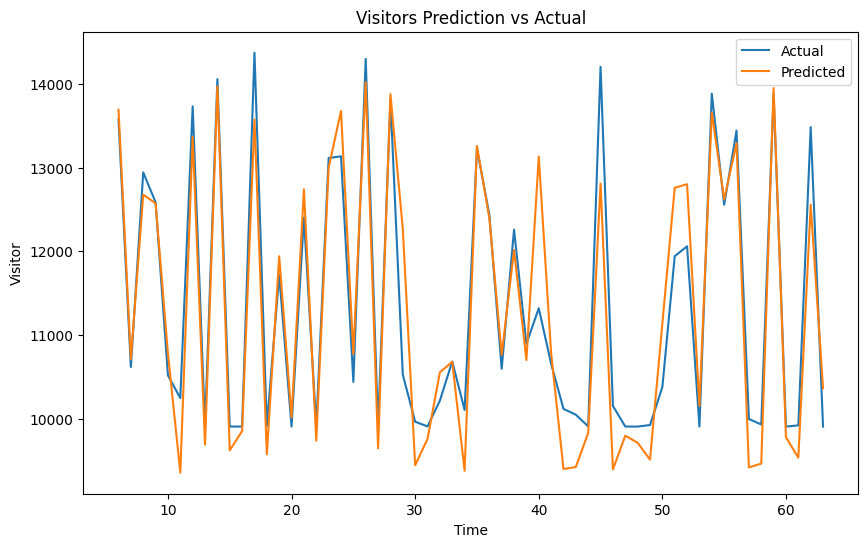

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_real, label='Actual')
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_70_train = []

for time_i in bulanprediksi2:
    bulanforecast_70_train.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_70_train = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_70_train = pd.to_datetime(bulanforecast_70_train, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_test_pred_real sama
min_length = min(len(bulanforecast_70_train), len(y_test_pred_real))
bulanforecast_70_train = bulanforecast_70_train[:min_length]
y_test_pred_real = y_test_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_test_pred_real, columns=['total_visitor'], index=bulanforecast_70_train)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9420 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        14155 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │         9774 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        13319 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        14051 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │         9488 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        14001 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13295 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │        13586 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │         9610 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10763 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

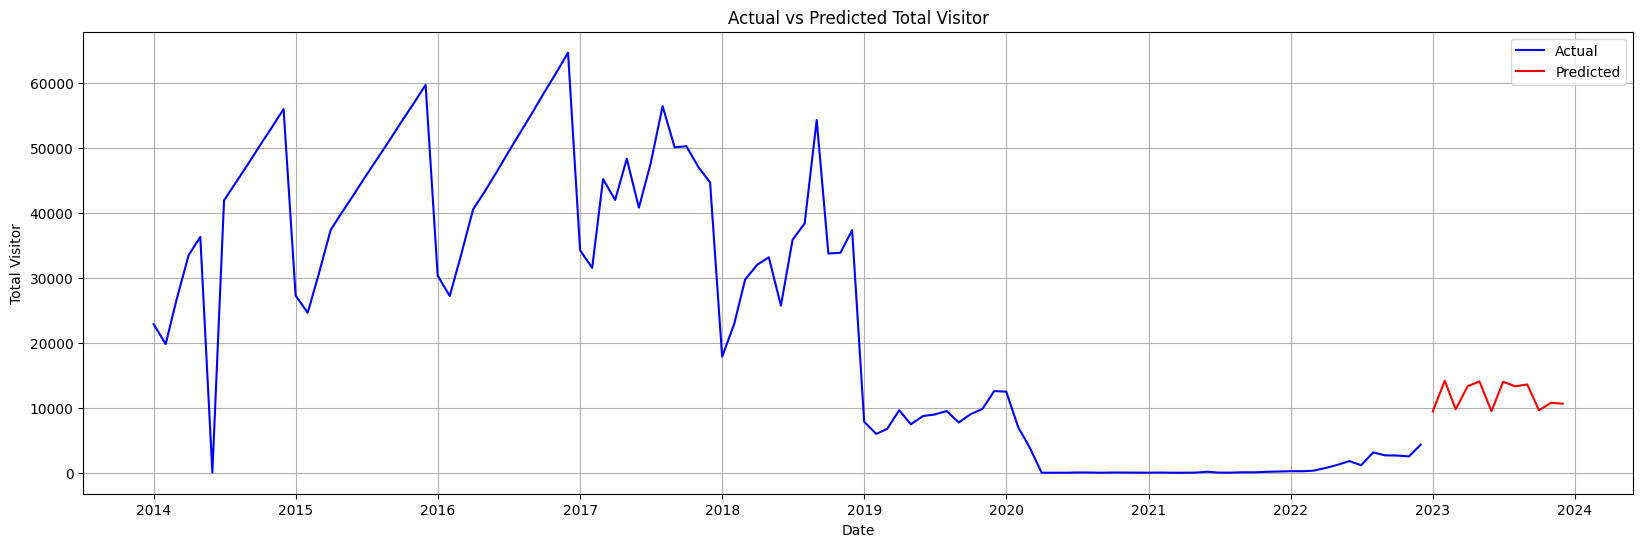

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


## On Test Set

In [ ]:
# Membuat prediksi visitor menggunakan X_test
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 60ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_test
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_copies)[:,1]
y_test_real

array([ 9923.13525846, 12306.05368516,  9907.30191343, 13629.0879957 ,
       12615.12058011,  9916.48525355, 14780.96384648, 13667.24635722,
       13331.73777607,  9917.2769208 , 10495.58984795, 10899.65681306,
       12860.06242769, 10114.7187333 ,  9907.69774706,  9908.01441396,
       12576.17055134, 10000.48114892, 10614.65660256, 10457.74815333,
       15022.50152488, 12744.16234209, 10666.66914097, 12529.54135023,
       14539.42616808,  9911.02274951])

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_test_pred_copies = np.repeat(y_test_pred, X_test.shape[-1], axis=-1)
y_test_pred_real = scaler.inverse_transform(y_test_pred_copies)[:,1]
y_test_pred_real

array([ 9487.088 , 14157.745 ,  9813.652 , 13517.749 , 14188.463 ,
        9553.626 , 14112.556 , 13378.602 , 13444.372 ,  9667.585 ,
       10770.218 , 10661.5205, 12244.852 ,  9391.329 ,  9882.991 ,
        9934.02  , 13378.644 ,  9431.614 , 10781.71  , 10707.828 ,
       14146.798 , 12446.752 , 10696.269 , 12652.289 , 14072.632 ,
        9597.033 ], dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_70_test = mean_squared_error(y_test_real, y_test_pred_real)
mae_70_test = mean_absolute_error(y_test_real, y_test_pred_real)
mape_70_test = mean_absolute_percentage_error(y_test_real, y_test_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_70_test, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_70_test, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_70_test, 2)}%")

Mean Absolute Error (MAE): 444.04
Mean Squared Error (MSE): 389738.75
Mean Absolute Percentage Error (MAPE): 0.04%


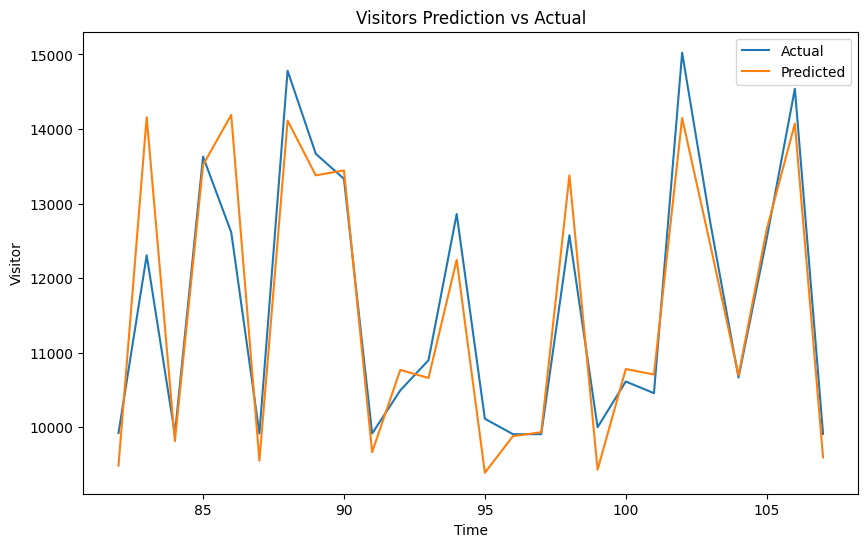

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[-y_test.shape[0]:], y_test_real, label='Actual')
plt.plot(ntt.index[-y_test.shape[0]:], y_test_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_70_test = []

for time_i in bulanprediksi2:
    bulanforecast_70_test.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_70_test = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_70_test = pd.to_datetime(bulanforecast_70_test, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_test_pred_real sama
min_length = min(len(bulanforecast_70_test), len(y_test_pred_real))
bulanforecast_70_test = bulanforecast_70_test[:min_length]
y_test_pred_real = y_test_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_test_pred_real, columns=['total_visitor'], index=bulanforecast_70_test)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9487 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        14157 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │         9813 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        13517 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        14188 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │         9553 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        14112 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13378 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │        13444 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │         9667 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10770 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

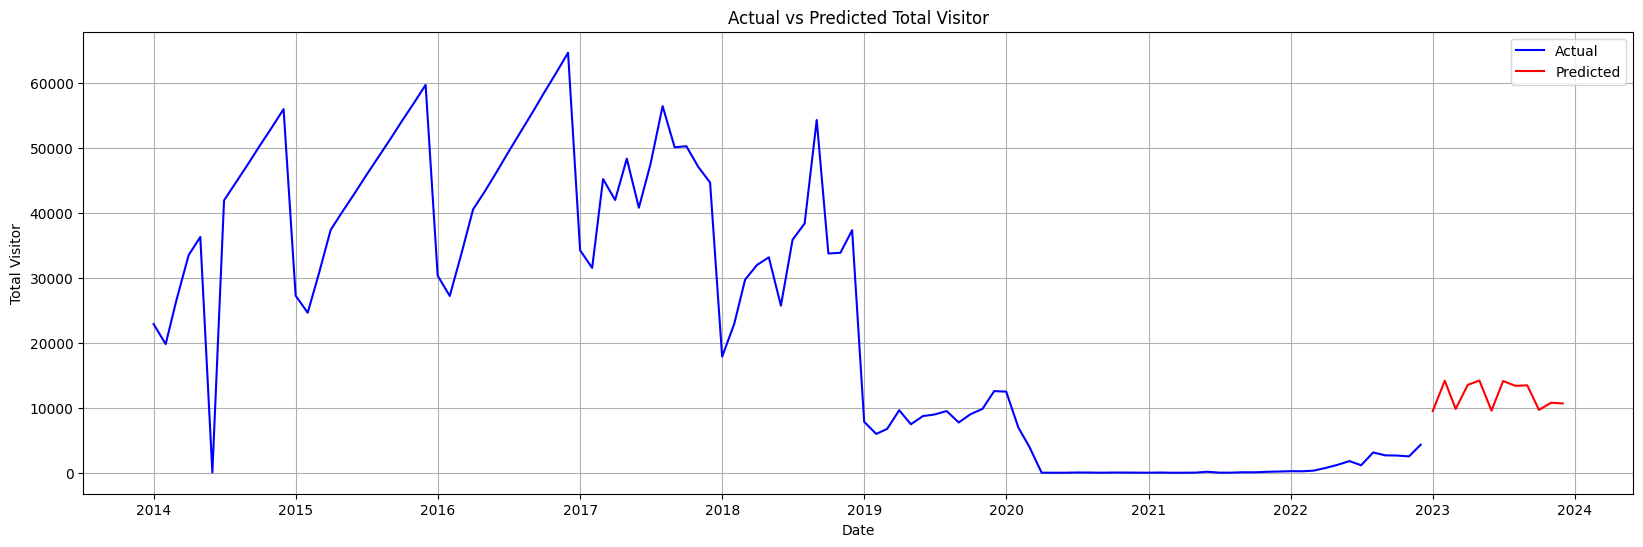

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


# Scenario 3



```
In this scenario i use 24 past data to predict 1 future data this data count
will be used to make trainX and trainY data and it will iterate 96 times because my dataset count is 120,
also i use simple GRU models with 1 only GRU layer + Output Dense Layer
```



In [ ]:
ntt_gru = ntt.copy()

In [ ]:
ntt_gru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            108 non-null    datetime64[ns]
 1   total_visitor       108 non-null    int64         
 2   total_accomodation  108 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.7 KB


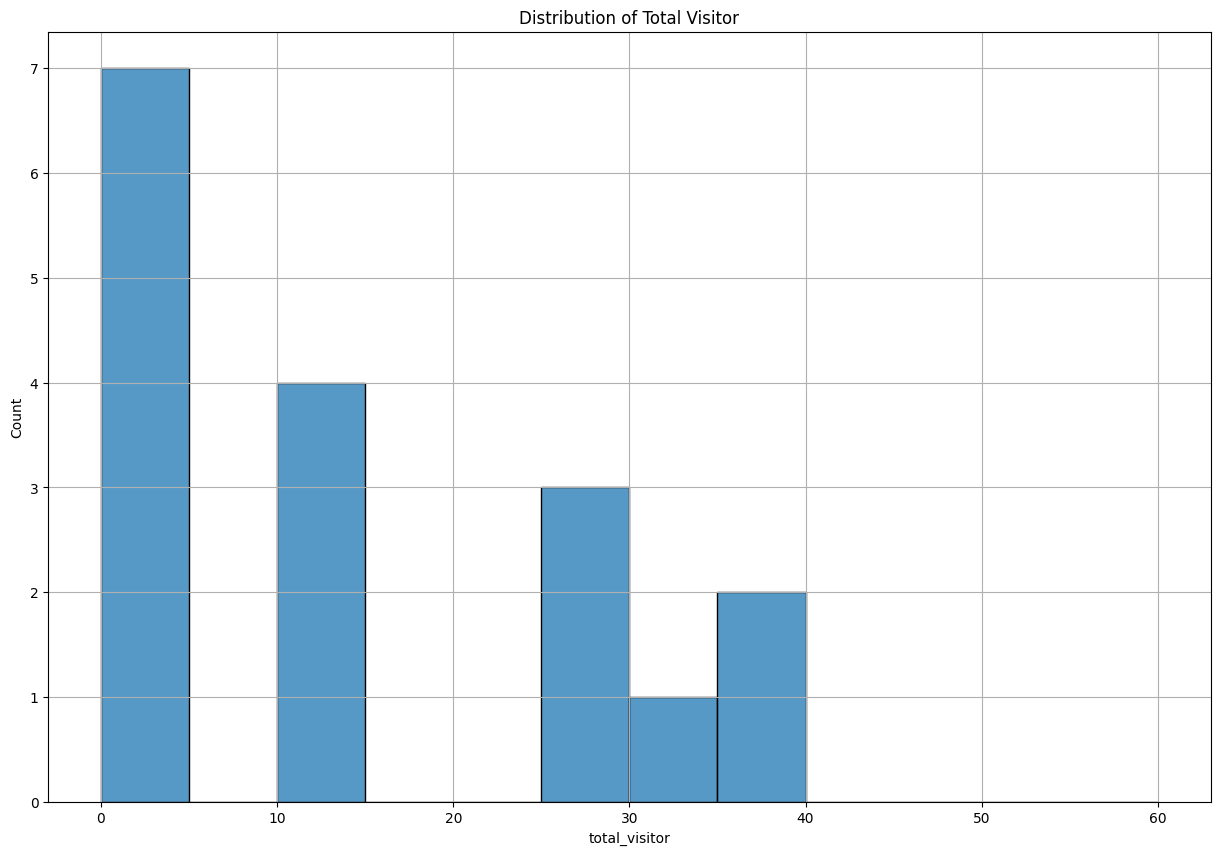

In [ ]:
# plot to see the visitor varience
plt.figure(figsize=(15, 10))
sns.histplot(ntt_gru['total_visitor'],bins=[i for i in range(0,61,5)], kde=False)
plt.title("Distribution of Total Visitor")
plt.grid()
plt.show()

In [ ]:
# Getting trainX and trainY
trainX = []
trainY = []
n_future = 1
n_past = 24

for i in range(n_past, len(scaled_data_train) - n_future + 1):
    trainX.append(scaled_data_train[i - n_past:i, 0:scaled_data_train.shape[1]])
    trainY.append(scaled_data_train[i + n_future - 1:i + n_future, 0])

trainX = np.array(trainX)
trainY = np.array(trainY)

# Memisahkan data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.4, random_state=42)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))

X_train shape == (50, 24, 2).
y_train shape == (50, 1).
X_test shape == (34, 24, 2).
y_test shape == (34, 1).


In [ ]:
# Define the GRU model
model = Sequential()
model.add(GRU(64, activation = 'tanh', input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))

model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                13056     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13121 (51.25 KB)
Trainable params: 13121 (51.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32,  verbose=1, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 3s 252ms/step - loss: 0.7862 - val_loss: 0.4846
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 0.5973 - val_loss: 0.2220
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 0.4469 - val_loss: 0.0697
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 0.3251 - val_loss: 0.0111
Epoch 5/100
3/3 [==============================] - 0s 29ms/step - loss: 0.2539 - val_loss: 0.0449
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 0.2165 - val_loss: 0.1668
Epoch 7/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2112 - val_loss: 0.3227
Epoch 8/100
3/3 [==============================] - 0s 32ms/step - loss: 0.2224 - val_loss: 0.3970
Epoch 9/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2279 - val_loss: 0.3661
Epoch 10/100
3/3 [==============================] - 0s 34ms/step - loss: 0.2148 - val_loss: 0.2885
Epoch 11/100
3/3 [

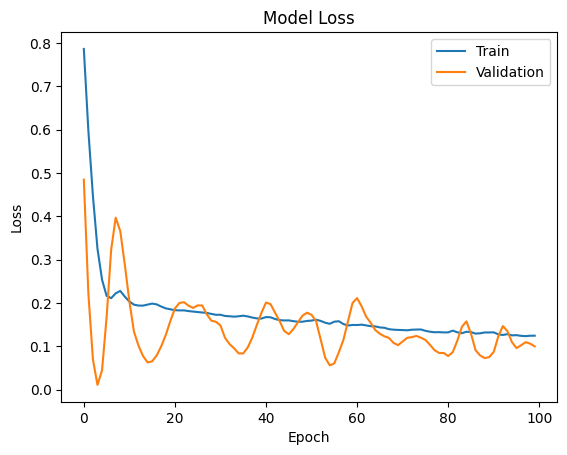

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Melakukan prediksi pada test set
predictions = model.predict(X_test)

2/2 [==============================] - 1s 8ms/step


In [ ]:
def plotting_actual_vs_pred(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    plt.plot(y_test, color='blue', label='Actual')
    plt.plot(y_pred, alpha=0.7, color='orange',
    label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Visitor')
    plt.legend()
    plt.show()

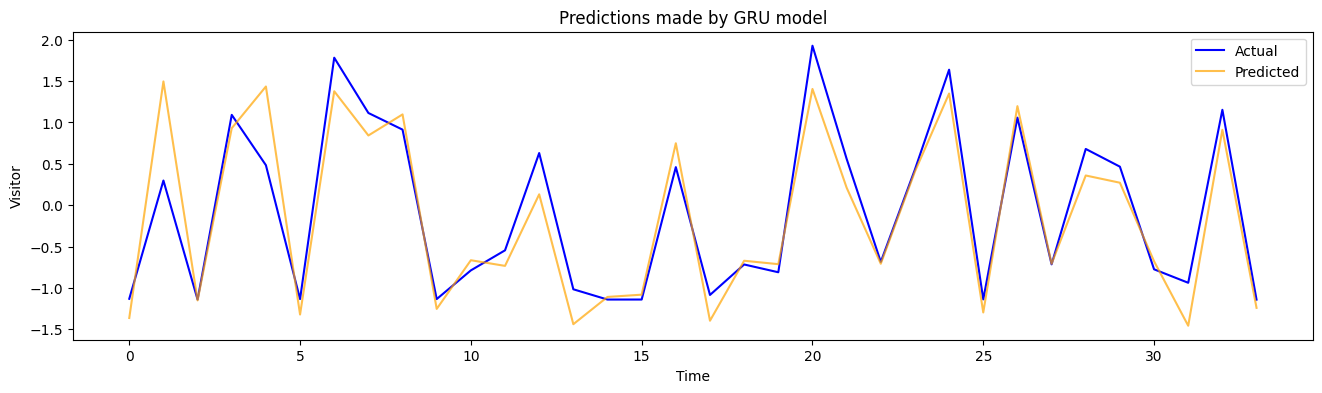

In [ ]:
plotting_actual_vs_pred(y_test, predictions, "Predictions made by GRU model")

##On Train

In [ ]:
# Membuat prediksi visitor menggunakan X_train
y_train_pred = model.predict(X_train)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_train
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
y_train_real = scaler.inverse_transform(y_train_copies)[:,1]
y_train_real

array([14056.35081128,  9906.19357928,  9905.24357858, 14371.67187751,
        9910.31024899, 11717.68658393,  9905.24357858, 12400.73708843,
        9905.24357858, 13113.95011521, 13134.21679685, 10438.90647275,
       14297.88848968,  9906.19357928, 13814.81313288, 10525.51487005,
        9963.58945501,  9907.30191343, 10215.73547458, 10682.97748635,
       10104.03122541, 13228.02936614, 12438.34128287, 10595.41908835,
       12257.76198283, 10893.08597487, 11319.31962302, 10656.69413361,
       10116.77706815, 10047.11035003,  9907.46024688, 14202.73008606,
       10152.24376102,  9906.27274601,  9905.48107875,  9923.76859226,
       10378.10642784, 11940.8575821 , 12058.974336  ,  9905.40191203,
       13883.45068357, 12555.5872028 , 13441.22535694,  9996.20614576,
        9930.33943045, 13869.75484012,  9905.56024548,  9919.81025601,
       13482.86705437,  9905.24357858])

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_train_pred_copies = np.repeat(y_train_pred, X_train.shape[-1], axis=-1)
y_train_pred_real = scaler.inverse_transform(y_train_pred_copies)[:,1]
y_train_pred_real

array([13959.178 ,  9671.847 ,  9930.026 , 13430.484 ,  9625.431 ,
       11709.831 , 10070.89  , 12684.3125,  9790.898 , 13196.476 ,
       13579.377 , 10654.68  , 14007.476 ,  9695.276 , 13901.963 ,
       12103.259 ,  9492.569 ,  9817.295 , 10498.686 , 10599.507 ,
        9399.624 , 13319.527 , 12294.366 , 10683.184 , 11886.794 ,
       10615.018 , 13001.806 , 10685.661 ,  9420.11  ,  9469.059 ,
        9908.516 , 12525.087 ,  9431.081 ,  9868.381 ,  9764.673 ,
        9563.875 , 10925.424 , 12524.859 , 12861.479 , 10176.959 ,
       13477.105 , 12750.385 , 13155.369 ,  9455.875 ,  9511.621 ,
       13803.619 ,  9844.191 ,  9588.302 , 12556.128 , 10346.597 ],
      dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_60_train = mean_squared_error(y_train_real, y_train_pred_real)
mae_60_train = mean_absolute_error(y_train_real, y_train_pred_real)
mape_60_train = mean_absolute_percentage_error(y_train_real, y_train_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_60_train, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_60_train, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_60_train, 2)}%")

Mean Absolute Error (MAE): 389.42
Mean Squared Error (MSE): 310273.04
Mean Absolute Percentage Error (MAPE): 0.03%


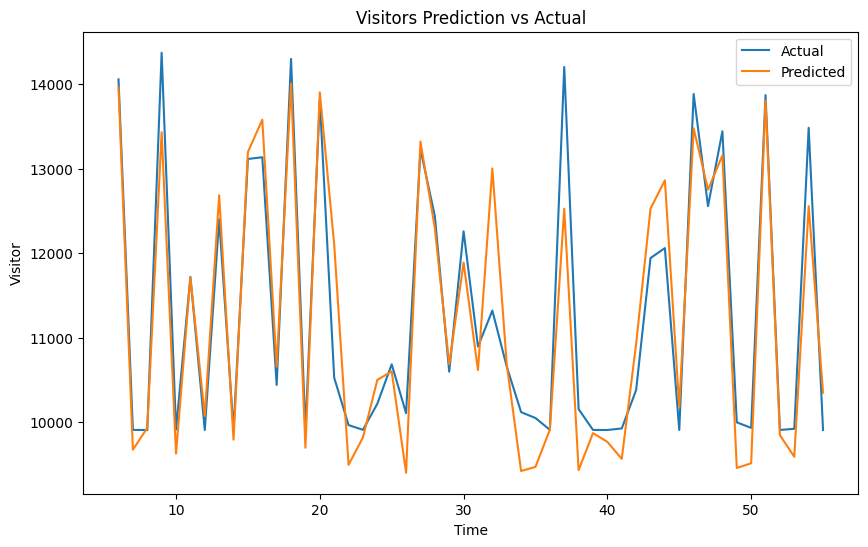

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_real, label='Actual')
plt.plot(ntt.index[sequence_length:y_train.shape[0]+sequence_length], y_train_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_60_train = []

for time_i in bulanprediksi2:
    bulanforecast_60_train.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_60_train = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_60_train = pd.to_datetime(bulanforecast_60_train, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_test_pred_real sama
min_length = min(len(bulanforecast_60_train), len(y_test_pred_real))
bulanforecast_60_train = bulanforecast_60_train[:min_length]
y_test_pred_real = y_test_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_test_pred_real, columns=['total_visitor'], index=bulanforecast_60_train)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9487 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        14157 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │         9813 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        13517 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        14188 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │         9553 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        14112 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13378 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │        13444 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │         9667 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10770 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

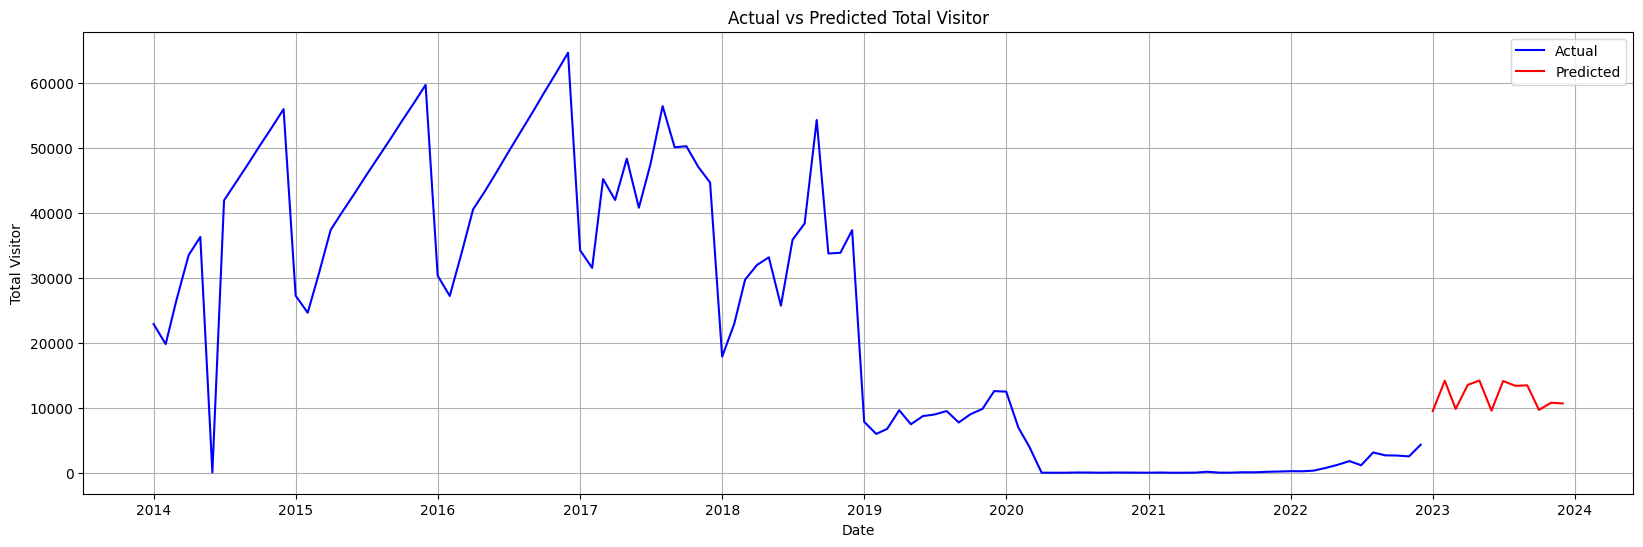

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


## On Test Set

In [ ]:
# Membuat prediksi visitor menggunakan X_test
y_test_pred = model.predict(X_test)

2/2 [==============================] - 0s 10ms/step


In [ ]:
# Mengembalikan skala nilai visitor dari y_test
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
y_test_real = scaler.inverse_transform(y_test_copies)[:,1]
y_test_real

array([ 9923.13525846, 12306.05368516,  9907.30191343, 13629.0879957 ,
       12615.12058011,  9916.48525355, 14780.96384648, 13667.24635722,
       13331.73777607,  9917.2769208 , 10495.58984795, 10899.65681306,
       12860.06242769, 10114.7187333 ,  9907.69774706,  9908.01441396,
       12576.17055134, 10000.48114892, 10614.65660256, 10457.74815333,
       15022.50152488, 12744.16234209, 10666.66914097, 12529.54135023,
       14539.42616808,  9911.02274951, 13573.27545448, 10617.26910449,
       12942.39582184, 12585.35389146, 10517.28153063, 10245.66049668,
       13731.37140458,  9906.27274601])

In [ ]:
# Mengembalikan skala nilai visitor dari y_train_pred
y_test_pred_copies = np.repeat(y_test_pred, X_test.shape[-1], axis=-1)
y_test_pred_real = scaler.inverse_transform(y_test_pred_copies)[:,1]
y_test_pred_real

array([ 9536.407, 14302.66 ,  9890.332, 13360.537, 14200.701,  9606.347,
       14105.089, 13213.908, 13638.219,  9719.348, 10700.039, 10586.139,
       12028.161,  9411.153,  9960.454, 10006.026, 13057.449,  9481.131,
       10689.562, 10620.915, 14151.293, 12162.576, 10629.148, 12486.643,
       14059.131,  9647.885, 13805.113, 10627.775, 12407.655, 12261.936,
       10679.031,  9380.467, 13328.329,  9740.393], dtype=float32)

In [ ]:
# Menghitung nilai ERROR dari hasil prediksi visitor terhadap data visitor asli dari train set
mse_60_test = mean_squared_error(y_test_real, y_test_pred_real)
mae_60_test = mean_absolute_error(y_test_real, y_test_pred_real)
mape_60_test = mean_absolute_percentage_error(y_test_real, y_test_pred_real)

print(f"Mean Absolute Error (MAE): {round(mae_60_test, 2)}")
print(f"Mean Squared Error (MSE): {round(mse_60_test, 2)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mape_60_test, 2)}%")

Mean Absolute Error (MAE): 429.83
Mean Squared Error (MSE): 361668.46
Mean Absolute Percentage Error (MAPE): 0.04%


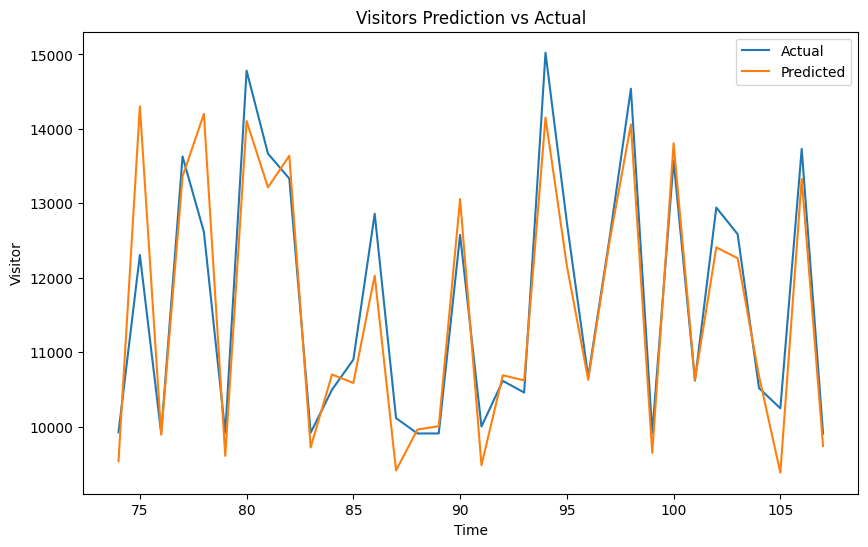

In [ ]:
# Melakukan plotting hasil prediksi visitor terhadap data visitor asli dari train set
plt.figure(figsize=(10, 6))
plt.plot(ntt.index[-y_test.shape[0]:], y_test_real, label='Actual')
plt.plot(ntt.index[-y_test.shape[0]:], y_test_pred_real, label='Predicted')
plt.title('Visitors Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Visitor')
plt.legend()
plt.show()

In [ ]:
train_datetime = pd.to_datetime(ntt['datetime'])
print(train_datetime)

0     2014-01-01
1     2014-02-01
2     2014-03-01
3     2014-04-01
4     2014-05-01
         ...    
103   2022-08-01
104   2022-09-01
105   2022-10-01
106   2022-11-01
107   2022-12-01
Name: datetime, Length: 108, dtype: datetime64[ns]


In [ ]:
# Predict for 12 month afterwards
n_past = 1
n_bulanprediksi = 12
bulanprediksi2 = pd.date_range(list(train_datetime)[-n_past], periods=n_bulanprediksi, freq='M').tolist()
print(bulanprediksi2)

[Timestamp('2022-12-31 00:00:00', freq='M'), Timestamp('2023-01-31 00:00:00', freq='M'), Timestamp('2023-02-28 00:00:00', freq='M'), Timestamp('2023-03-31 00:00:00', freq='M'), Timestamp('2023-04-30 00:00:00', freq='M'), Timestamp('2023-05-31 00:00:00', freq='M'), Timestamp('2023-06-30 00:00:00', freq='M'), Timestamp('2023-07-31 00:00:00', freq='M'), Timestamp('2023-08-31 00:00:00', freq='M'), Timestamp('2023-09-30 00:00:00', freq='M'), Timestamp('2023-10-31 00:00:00', freq='M'), Timestamp('2023-11-30 00:00:00', freq='M')]


In [ ]:
import matplotlib.dates as mdates

bulanforecast_60_test = []

for time_i in bulanprediksi2:
    bulanforecast_60_test.append(time_i.date())

# Generate the forecast dates from January 2023 to December 2023
bulanforecast_60_test = pd.date_range(start='2023-01-01', end='2023-12-01', freq='MS')
bulanforecast_60_test = pd.to_datetime(bulanforecast_60_test, format='%Y-%m-%d')

# Memastikan panjang forecast_dates dan y_test_pred_real sama
min_length = min(len(bulanforecast_60_test), len(y_test_pred_real))
bulanforecast_60_test = bulanforecast_60_test[:min_length]
y_test_pred_real = y_test_pred_real[:min_length]

# Create a DataFrame from the predictions array
df_test = pd.DataFrame(y_test_pred_real, columns=['total_visitor'], index=bulanforecast_60_test)

ntt_rnn_copy = ntt.copy()
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%m/%d/%Y')
ntt_rnn_copy['datetime'] = pd.to_datetime(ntt_rnn_copy['datetime'], format='%Y-%m-%d')
ntt_rnn_copy.set_index("datetime", inplace=True)


In [ ]:
from tabulate import tabulate

# Create a list of forecast dates and prediction values
data = list(zip(df_test.index, map(int, df_test['total_visitor'])))

# Create a list of headers for the table
headers = ['Date', 'Prediction']
table = tabulate(data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒═════════════════════╤══════════════╕
│ Date                │   Prediction │
╞═════════════════════╪══════════════╡
│ 2023-01-01 00:00:00 │         9536 │
├─────────────────────┼──────────────┤
│ 2023-02-01 00:00:00 │        14302 │
├─────────────────────┼──────────────┤
│ 2023-03-01 00:00:00 │         9890 │
├─────────────────────┼──────────────┤
│ 2023-04-01 00:00:00 │        13360 │
├─────────────────────┼──────────────┤
│ 2023-05-01 00:00:00 │        14200 │
├─────────────────────┼──────────────┤
│ 2023-06-01 00:00:00 │         9606 │
├─────────────────────┼──────────────┤
│ 2023-07-01 00:00:00 │        14105 │
├─────────────────────┼──────────────┤
│ 2023-08-01 00:00:00 │        13213 │
├─────────────────────┼──────────────┤
│ 2023-09-01 00:00:00 │        13638 │
├─────────────────────┼──────────────┤
│ 2023-10-01 00:00:00 │         9719 │
├─────────────────────┼──────────────┤
│ 2023-11-01 00:00:00 │        10700 │
├─────────────────────┼──────────────┤
│ 2023-12-01 00:00:00 │  

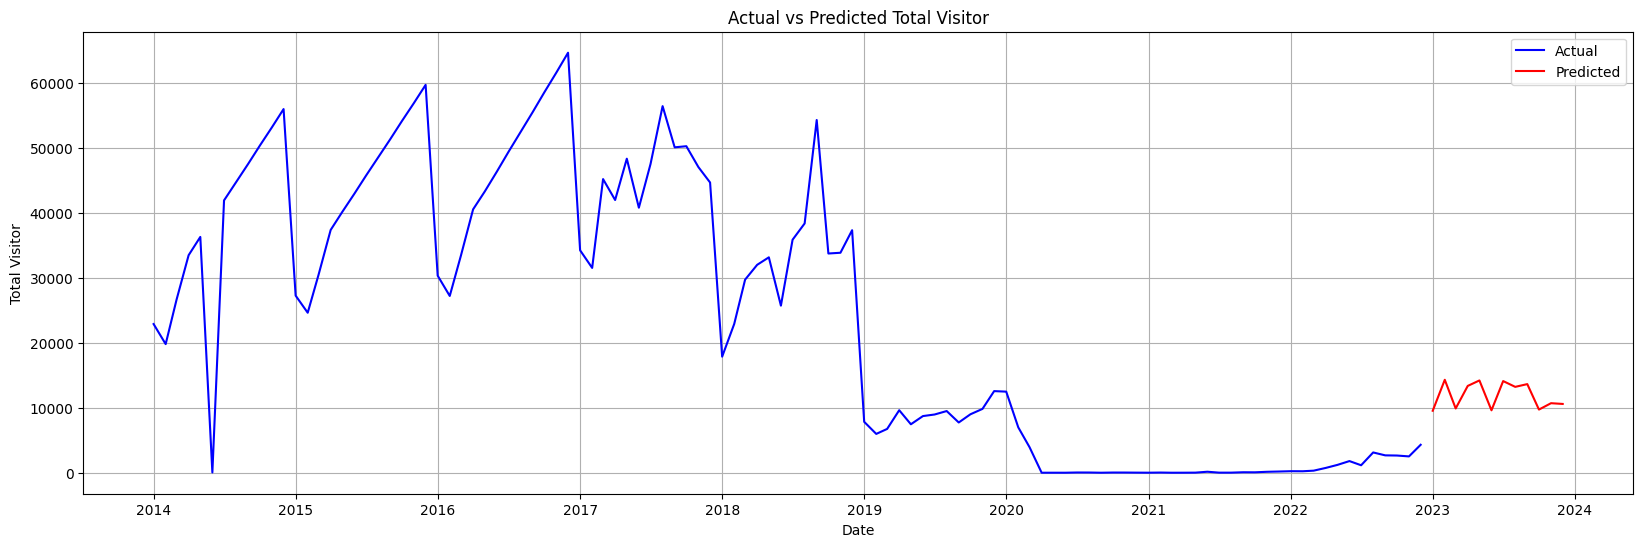

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(20, 6))
plt.plot(ntt_rnn_copy.index, ntt_rnn_copy['total_visitor'], color='blue', label='Actual')
plt.plot(df_test.index, df_test['total_visitor'], color='red', label='Predicted')
plt.title('Actual vs Predicted Total Visitor')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Total Visitor')
plt.legend()
plt.show()


#Conclusion

In [ ]:
# Define the data for each scenario
scenario_data = [
    {
        'Scenario': 'Scenario 1',
        'Model': 'GRU Train 80',
        'MSE': mse_80_train,
        'MAE': mae_80_train,
        'MAPE': mape_80_train
    },
    {
    'Scenario': 'Scenario 1',
        'Model': 'GRU Test 80',
        'MSE': mse_80_test,
        'MAE': mae_80_test,
        'MAPE': mape_80_test
    },
   {
        'Scenario': 'Scenario 2',
        'Model': 'GRU Train 70',
        'MSE': mse_70_train,
        'MAE': mae_70_train,
        'MAPE': mape_70_train
    },
    {
    'Scenario': 'Scenario 2',
        'Model': 'GRU Test 70',
        'MSE': mse_70_test,
        'MAE': mae_70_test,
        'MAPE': mape_70_test
    },
     {
        'Scenario': 'Scenario 3',
        'Model': 'GRU Train 60',
        'MSE': mse_60_train,
        'MAE': mae_60_train,
        'MAPE': mape_60_train
    },
    {
    'Scenario': 'Scenario 3',
        'Model': 'GRU Test 60',
        'MSE': mse_60_test,
        'MAE': mae_60_test,
        'MAPE': mape_60_test
    },
]

# Create a DataFrame from the scenario data
df = pd.DataFrame(scenario_data)

# Convert DataFrame to a list of rows
rows = df.values.tolist()

# Create a list of headers
headers = df.columns.tolist()

# Generate the table
table4 = tabulate(rows, headers=headers, tablefmt='fancy_grid')

# Print the table
print(table4)



╒════════════╤══════════════╤════════╤═════════╤═══════════╕
│ Scenario   │ Model        │    MSE │     MAE │      MAPE │
╞════════════╪══════════════╪════════╪═════════╪═══════════╡
│ Scenario 1 │ GRU Train 80 │ 303187 │ 408.392 │ 0.0360969 │
├────────────┼──────────────┼────────┼─────────┼───────────┤
│ Scenario 1 │ GRU Test 80  │ 512361 │ 541.215 │ 0.0454427 │
├────────────┼──────────────┼────────┼─────────┼───────────┤
│ Scenario 2 │ GRU Train 70 │ 302034 │ 390.043 │ 0.0349754 │
├────────────┼──────────────┼────────┼─────────┼───────────┤
│ Scenario 2 │ GRU Test 70  │ 389739 │ 444.042 │ 0.037082  │
├────────────┼──────────────┼────────┼─────────┼───────────┤
│ Scenario 3 │ GRU Train 60 │ 310273 │ 389.415 │ 0.0343761 │
├────────────┼──────────────┼────────┼─────────┼───────────┤
│ Scenario 3 │ GRU Test 60  │ 361668 │ 429.827 │ 0.0356815 │
╘════════════╧══════════════╧════════╧═════════╧═══════════╛
